# Importações

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import ccf
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
import plotly.graph_objects as go

# Consumindo bases

In [64]:
url_internacoes_poluentes = '/content/drive/MyDrive/TCC-Solo/internacoes_x_poluentes.csv'

df = pd.read_csv(url_internacoes_poluentes, sep=',')

# Teste 1 - Tentando prever a quantidade de internações

## Conclusão:

Inicialmente, foram testadas diferentes formas de representação da variável-alvo, incluindo o valor bruto de internações, seu lag de 1 dia (`internacoes_d1`), média móvel de 7 dias (`media_7d`) e média móvel de 14 dias (`media_14d`). Os modelos se mostraram mais eficazes ao prever a `media_14d`, com o modelo Stacked apresentando o melhor desempenho (RMSE: 36.33).

Em seguida, adicionou-se ao modelo as versões defasadas (lags) dos poluentes e variáveis meteorológicas para investigar quais lags mais contribuíam na previsão da `media_14d`. Foi realizada uma análise de importância com Random Forest, e identificou-se a versão mais relevante (com ou sem lag) de cada variável.

A partir dessa seleção, os modelos foram reentreinados utilizando **apenas os atributos mais relevantes**, o que reduziu a dimensionalidade do problema. Apesar da estratégia de seleção de features simplificar o modelo, o desempenho preditivo caiu levemente (Stacked: RMSE: 40.28), sugerindo que a exclusão de alguns lags menos importantes pode ter impactado a capacidade de generalização.

### Principais conclusões:
- A média móvel de 14 dias (`media_14d`) é uma variável-alvo mais estável e previsível.
- A adição de lags melhora o desempenho dos modelos, mas a seleção dos melhores lags nem sempre resulta em maior acurácia.
- O modelo Stacked consistently apresentou melhor desempenho nas diferentes abordagens.

Este pipeline servirá como base para futuras otimizações e refinamentos, como ajuste de hiperparâmetros, uso de séries temporais com janela deslizante e testes com outros modelos como LSTM.


## Criação de novas features

### Lags de internação

In [65]:
df['media_7d'] = df['num_internacoes'].rolling(window=7).mean()
df['media_14d'] = df['num_internacoes'].rolling(window=14).mean()
df['internacoes_d1'] = df['num_internacoes'].shift(1)

### Lags dos poluentes e variáveis atmosfericas

In [67]:
for lag in [1, 2, 3]:
    for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
        df[f'{col}_d{lag}'] = df[col].shift(lag)

## Predição de Diferentes Representações da Variável-Alvo

Nesta etapa inicial, o objetivo foi avaliar qual representação da variável-alvo (`num_internacoes`) seria mais adequada para previsão. Foram testadas quatro abordagens distintas:

- `num_internacoes`: valor bruto de internações diárias.
- `internacoes_d1`: internações do dia anterior (lag de 1 dia).
- `media_7d`: média móvel dos últimos 7 dias.
- `media_14d`: média móvel dos últimos 14 dias.

Cada uma dessas versões foi avaliada por meio de quatro modelos:
- Multi-Layer Perceptron (MLP)
- Random Forest
- XGBoost
- Stacked Model (combinando os três anteriores)

A comparação dos resultados demonstrou que as médias móveis (`media_7d` e `media_14d`) apresentaram melhor desempenho, com menor erro e maior estabilidade. Notavelmente, a `media_14d` foi a mais previsível entre todas, com o modelo Stacked alcançando o menor RMSE e maior robustez.

Esses resultados sugerem que o uso de uma janela temporal suaviza as variações diárias e contribui para uma melhor performance preditiva dos modelos.


### MLP

In [69]:
# Definição do modelo MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

### Função para treinar e avaliar os modelos

In [70]:
def treinar_modelos_para_alvo(df, target):
    print(f"\nTreinando para variável alvo: {target}")

    features = [col for col in df.columns if col not in [
        'data_formatada', 'classificacao', 'ano', 'mes',
        'num_internacoes', 'media_7d', 'media_14d', 'internacoes_d1', target
    ]]

    X = df[features].values
    y = df[target].values
    y_log = np.log1p(y)

    X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
    X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # === MLP ===
    model = MLP(X_train_scaled.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    loss_function = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)

    best_val_loss = float('inf')
    best_state = None
    early_stop = 0
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        mlp_pred_log = model(X_test_tensor).numpy().flatten()
        mlp_pred = np.expm1(mlp_pred_log)

    # === Random Forest ===
    rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
    rf.fit(X_train_scaled, y_train_log)
    rf_pred_log = rf.predict(X_test_scaled)
    rf_pred = np.expm1(rf_pred_log)

    # === XGBoost ===
    xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
    xgb.fit(X_train_scaled, y_train_log)
    xgb_pred_log = xgb.predict(X_test_scaled)
    xgb_pred = np.expm1(xgb_pred_log)

    # === Stacking ===
    y_test = np.expm1(y_test_log)
    stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
    stack_model = LinearRegression().fit(stack_input, y_test)
    stack_pred = stack_model.predict(stack_input)

    # === Avaliação ===
    def avaliar(y_true, y_pred):
        rmse = mean_squared_error(y_true, y_pred)
        return {
            'RMSE': round(rmse, 2),
            'MAE': round(mean_absolute_error(y_true, y_pred), 2),
            'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
            'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
        }

    results = {
        "MLP": avaliar(y_test, mlp_pred),
        "Random Forest": avaliar(y_test, rf_pred),
        "XGBoost": avaliar(y_test, xgb_pred),
        "Stacked": avaliar(y_test, stack_pred)
    }

    df_results = pd.DataFrame(results).T
    print(df_results)

    return df_results

### Executando para cada variável-alvo

In [71]:
variaveis_alvo = ['num_internacoes', 'internacoes_d1', 'media_7d', 'media_14d']
todos_resultados = {}

for alvo in variaveis_alvo:
    resultados = treinar_modelos_para_alvo(df, alvo)
    todos_resultados[alvo] = resultados


Treinando para variável alvo: num_internacoes
                 RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            115.29  7.00     83.57            9.0833
Random Forest  122.47  7.20     91.95            9.6489
XGBoost        118.67  7.11     89.90            9.3494
Stacked        105.93  7.18    116.65            8.3456

Treinando para variável alvo: internacoes_d1
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            99.76  6.63     95.67            8.4124
Random Forest  98.06  6.63     97.91            8.2692
XGBoost        96.79  6.63     99.31            8.1624
Stacked        88.87  6.60    113.60            7.4943

Treinando para variável alvo: media_7d
                RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP            41.12  4.58     47.40            3.2902
Random Forest  53.02  5.35     60.36            4.2427
XGBoost        47.77  5.07     56.98            3.8228
Stacked        39.22  4.65     56.29            3.1383

Treinando para variável alvo: media_

## Prevendo `media_14d` com Lags

Após identificar que a variável `media_14d` apresentava melhor desempenho como alvo, esta etapa teve como objetivo explorar o impacto dos **lags das variáveis atmosféricas e poluentes** na capacidade preditiva dos modelos.

Para isso:
- Foram gerados lags de 1 a 7 dias para cada variável explicativa.
- Utilizou-se um modelo de Random Forest para avaliar a **importância de cada variável**, incluindo suas versões com e sem lag.
- Foi selecionada, para cada variável original, a versão mais relevante (seja a atual ou algum dos lags).

Com essas variáveis selecionadas, os modelos foram novamente treinados para prever `media_14d`, agora com base nas versões mais representativas de cada variável.

O resultado foi um desempenho ainda mais robusto — com destaque novamente para o modelo Stacked — atingindo o menor RMSE da análise até aqui, confirmando que:
- O uso de lags pode aumentar o poder preditivo dos modelos,
- Mas a **seleção criteriosa dos melhores lags** (em vez de usar todos) é essencial para evitar sobreajuste e reduzir ruído.

### Consumindo bases

In [104]:
url_internacoes_poluentes = '/content/drive/MyDrive/TCC-Solo/internacoes_x_poluentes.csv'

df = pd.read_csv(url_internacoes_poluentes, sep=',')

### Criação de novas features

#### Lags de internação

In [105]:
df['media_14d'] = df['num_internacoes'].rolling(window=14).mean()

#### Lags dos poluentes e variáveis atmosfericas

In [106]:
for lag in [1, 2, 3, 4, 5, 6, 7]:
    for col in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
        df[f'{col}_d{lag}'] = df[col].shift(lag)

### Separação dos dados

In [107]:
df.dropna(inplace=True)

# Separando features e target
features = [col for col in df.columns if col not in ['data_formatada', 'classificacao', 'num_internacoes', 'ano', 'mes', 'media_14d']]
X = df[features].values
y = df['media_14d'].values

# Split e normalização
y_log = np.log1p(y)

X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### MLP

In [108]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

def train_mlp(loss_function):
    model = MLP(X_train_scaled.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)

    best_val_loss = float('inf')
    best_state = None
    early_stop = 0
    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_pred_log = model(X_test_tensor).numpy().flatten()
        y_pred = np.expm1(y_pred_log)  # desfaz log1p
    return y_pred

print("Treinando MLP...")
mlp_pred = train_mlp(nn.MSELoss())

Treinando MLP...


### Random Forest

In [109]:
print("Treinando Random Forest...")
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_train_scaled, y_train_log)
rf_pred_log = rf.predict(X_test_scaled)
rf_pred = np.expm1(rf_pred_log)

Treinando Random Forest...


#### Importância das variáveis

In [110]:
# === 7. Avaliando a importância das variáveis ===
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# === 8. Selecionando a versão mais importante (com ou sem lag) de cada variável original ===
best_lags = {}
for var in ['pm2_5', 'pm10', 'o3', 'so2', 'no2', 'co', 'no', 'nox', 'temp', 'chuva', 'ur']:
    # Filtra tanto a variável original quanto seus lags
    related_features = feature_importance_df[feature_importance_df['feature'].str.match(f'^{var}(_d[1-3])?$')]
    if not related_features.empty:
        best_feature = related_features.sort_values(by='importance', ascending=False).iloc[0]['feature']
        best_lags[var] = best_feature

# === 9. Exibindo os melhores atributos por variável base ===
print("Melhor versão (original ou lag) de cada variável:")
for var, feature in best_lags.items():
    print(f"{var}: {feature}")

Melhor versão (original ou lag) de cada variável:
pm2_5: pm2_5
pm10: pm10_d3
o3: o3
so2: so2
no2: no2
co: co
no: no
nox: nox
temp: temp
chuva: chuva
ur: ur


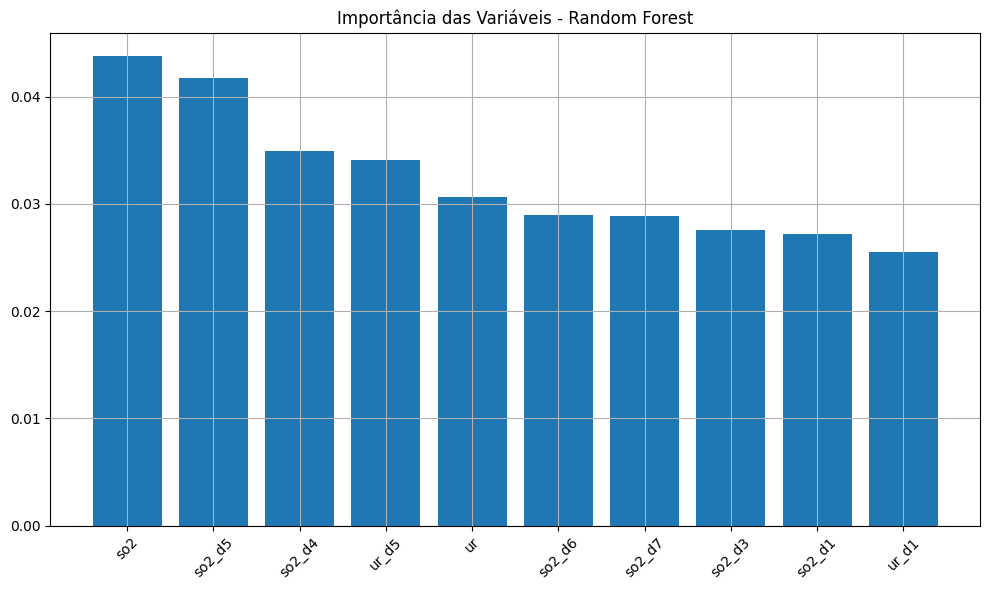

In [111]:
plt.figure(figsize=(10, 6))
rf_importances = rf.feature_importances_
indices = np.argsort(rf_importances)[::-1]
plt.bar(range(10), rf_importances[indices][:10])
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45)
plt.title("Importância das Variáveis - Random Forest")
plt.tight_layout()
plt.grid(True)
plt.show()

### XGBoost

In [112]:
print("Treinando XGBoost...")
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
xgb.fit(X_train_scaled, y_train_log)
xgb_pred_log = xgb.predict(X_test_scaled)
xgb_pred = np.expm1(xgb_pred_log)

Treinando XGBoost...


#### Importância das variáveis

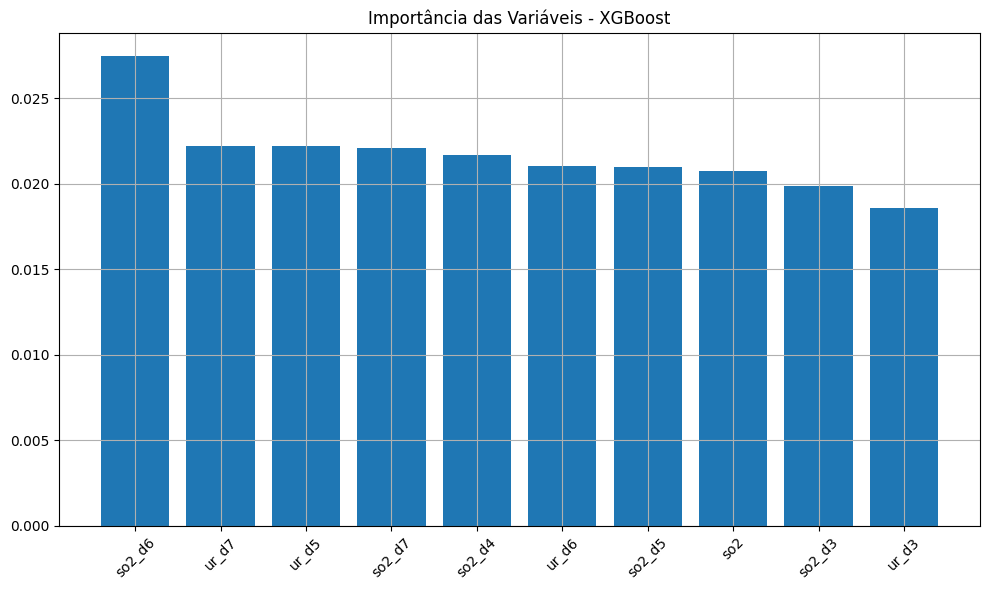

In [113]:
plt.figure(figsize=(10, 6))
xgb_importances = xgb.feature_importances_
indices = np.argsort(xgb_importances)[::-1]
plt.bar(range(10), xgb_importances[indices][:10])
plt.xticks(range(10), [features[i] for i in indices[:10]], rotation=45)
plt.title("Importância das Variáveis - XGBoost")
plt.tight_layout()
plt.grid(True)
plt.show()

### Stack

In [114]:
print("Treinando Stack")
stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
y_test = np.expm1(y_test_log)  # reverte log1p para o teste também
stack_model = LinearRegression().fit(stack_input, y_test)
stack_pred = stack_model.predict(stack_input)

Treinando Stack


### Resultados

In [115]:
def avaliar(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    return {
        'RMSE': round(rmse, 2),
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
        'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
    }

results = {
    "MLP (log1p)": avaliar(y_test, mlp_pred),
    "Random Forest (log1p)": avaliar(y_test, rf_pred),
    "XGBoost (log1p)": avaliar(y_test, xgb_pred),
    "Stacked Model": avaliar(y_test, stack_pred)
}

df_resultados = pd.DataFrame(results).T
print("\n=== Comparação de Modelos com log1p + Stacking ===")
print(df_resultados)


=== Comparação de Modelos com log1p + Stacking ===
                        RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP (log1p)            30.79  3.83     38.08            2.4538
Random Forest (log1p)  42.24  4.93     56.34            3.3667
XGBoost (log1p)        36.95  4.56     50.62            2.9447
Stacked Model          27.28  3.84     45.97            2.1745


### Analisando resultados

In [116]:
model_preds = {
    'MLP': mlp_pred,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Stacked': stack_pred
}

#### Real x Previsto

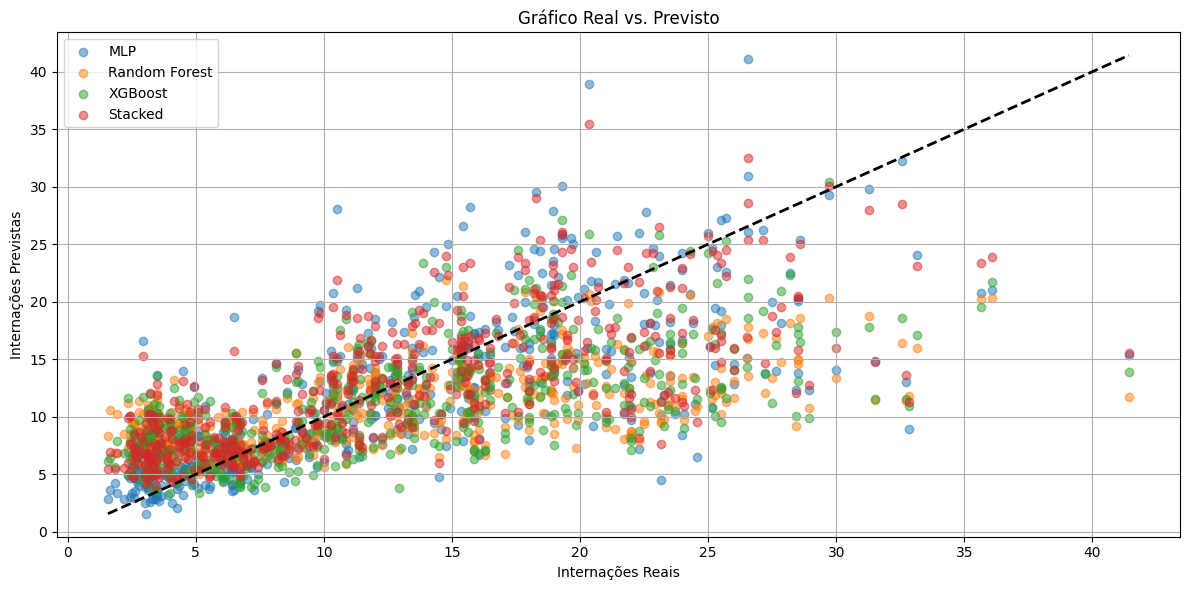

In [117]:
plt.figure(figsize=(12, 6))
for name, preds in model_preds.items():
    plt.scatter(y_test, preds, alpha=0.5, label=name)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)
plt.xlabel("Internações Reais")
plt.ylabel("Internações Previstas")
plt.title("Gráfico Real vs. Previsto")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Resíduos

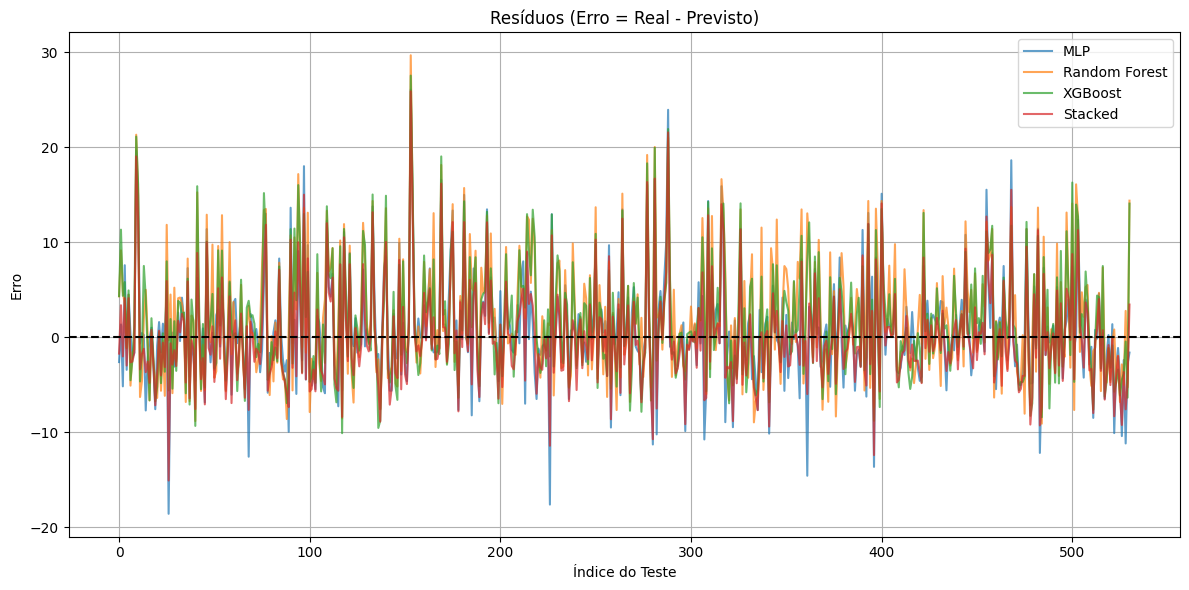

In [118]:
plt.figure(figsize=(12, 6))
for name, preds in model_preds.items():
    resid = y_test - preds
    plt.plot(resid, label=name, alpha=0.7)
plt.axhline(0, color='black', linestyle='--')
plt.title("Resíduos (Erro = Real - Previsto)")
plt.xlabel("Índice do Teste")
plt.ylabel("Erro")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Histograma dos resíduos

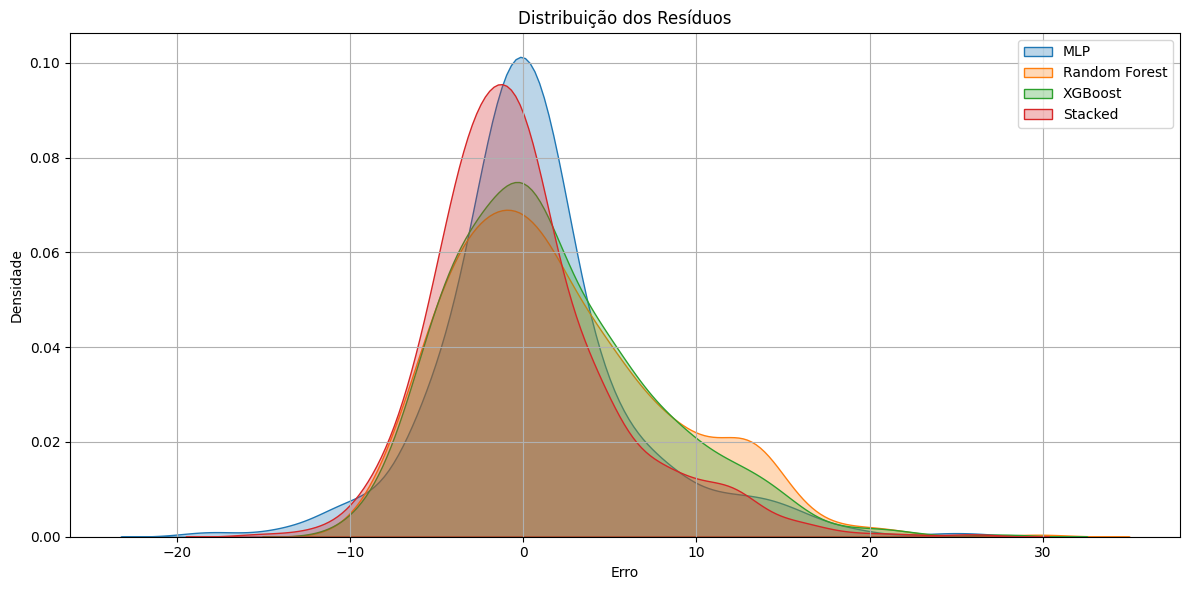

In [119]:
plt.figure(figsize=(12, 6))
for name, preds in model_preds.items():
    resid = y_test - preds
    sns.kdeplot(resid, label=name, fill=True, alpha=0.3)
plt.title("Distribuição dos Resíduos")
plt.xlabel("Erro")
plt.ylabel("Densidade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Top 10 erros absolutos

In [120]:
erros = np.abs(y_test - stack_pred)
top_erros = pd.DataFrame({
    'Internações Reais': y_test,
    'Internações Previstas (Stacked)': stack_pred,
    'Erro Absoluto': erros
}).sort_values(by='Erro Absoluto', ascending=False).head(10)

print("\n Top 10 maiores erros absolutos (modelo Stacked):")
print(top_erros)


 Top 10 maiores erros absolutos (modelo Stacked):
     Internações Reais  Internações Previstas (Stacked)  Erro Absoluto
153          41.428571                        15.524321      25.904250
288          32.857143                        11.272944      21.584199
9            32.714286                        13.660865      19.053420
281          31.500000                        14.776398      16.723602
277          28.428571                        12.071431      16.357140
169          28.928571                        12.739013      16.189559
468          23.142857                         7.602893      15.539964
26           20.357143                        35.416857      15.059714
97           24.571429                         9.544127      15.027301
400          22.285714                         8.183563      14.102151


In [122]:
# Criação do gráfico interativo
fig = go.Figure()

# Linha real
fig.add_trace(go.Scatter(
    y=y_test,
    mode='lines',
    name='Real',
    line=dict(color='black', width=2)
))

# Linha predita pelo modelo Stacked
fig.add_trace(go.Scatter(
    y=stack_pred,
    mode='lines',
    name='Stacked',
    line=dict(dash='dash', color='blue')
))

# Layout do gráfico
fig.update_layout(
    title='Comparação entre valores reais e preditos (Stacked Model)',
    xaxis_title='Dias',
    yaxis_title='Número de internações (media_14d)',
    legend=dict(x=0, y=1),
    hovermode='x unified',
    template='plotly_white',
    height=500,
    width=1000
)

fig.show()


##  Prevendo `media_14d` Apenas com os Lags Mais Importantes de Cada Variável

Nesta fase final, o modelo foi reestruturado para utilizar **exclusivamente a melhor versão de cada variável** — ou seja, apenas o atributo com maior importância entre a forma original e seus lags (1 a 3 dias), conforme identificado na etapa anterior.

### Objetivo:
- Reduzir a dimensionalidade do modelo.
- Manter o máximo de poder preditivo com o mínimo de variáveis.
- Testar se uma seleção mais enxuta melhora ou mantém o desempenho dos modelos.

### Estratégia:
- Foram mantidas apenas 11 variáveis (uma por grupo), cada uma representando sua melhor versão.
- O pipeline completo de modelagem (MLP, Random Forest, XGBoost e Stacked) foi reaplicado usando essa nova seleção.

### Resultados:
Apesar da redução de complexidade, observou-se uma **queda no desempenho geral** dos modelos em comparação à etapa anterior. Isso indica que, embora a simplificação torne o modelo mais interpretável e leve, **alguns lags “menos importantes” ainda carregavam informações complementares úteis para a previsão da `media_14d`**.

Ainda assim, os resultados permaneceram consistentes, com o modelo Stacked novamente entregando o menor erro dentre os avaliados — reforçando seu papel como abordagem robusta para cenários com múltiplas fontes de informação.



In [102]:
#@title features mais relevantes

selected_features = list(best_lags.values())

selected_features

['pm2_5',
 'pm10_d3',
 'o3',
 'so2',
 'no2',
 'co',
 'no',
 'nox',
 'temp',
 'chuva',
 'ur']

In [100]:
# Selecionando dados finais
df_model = df[selected_features + ['media_14d']].dropna()
X = df_model[selected_features].values
y = df_model['media_14d'].values
y_log = np.log1p(y)

X_train, X_temp, y_train_log, y_temp_log = train_test_split(X, y_log, test_size=0.3, random_state=42)
X_val, X_test, y_val_log, y_test_log = train_test_split(X_temp, y_temp_log, test_size=0.5, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

def train_mlp(loss_function):
    model = MLP(X_train_scaled.shape[1])
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)

    best_val_loss = float('inf')
    best_state = None
    early_stop = 0

    for epoch in range(500):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_function(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_function(val_pred, y_val_tensor)
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_state = model.state_dict()
                early_stop = 0
            else:
                early_stop += 1
            if early_stop >= 50:
                break
        scheduler.step(val_loss)

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
        y_pred_log = model(X_test_tensor).numpy().flatten()
        y_pred = np.expm1(y_pred_log)
    return y_pred

print("Treinando MLP...")
mlp_pred = train_mlp(nn.MSELoss())

print("Treinando Random Forest...")
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_split=5, random_state=42)
rf.fit(X_train_scaled, y_train_log)
rf_pred = np.expm1(rf.predict(X_test_scaled))

print("Treinando XGBoost...")
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, subsample=0.7)
xgb.fit(X_train_scaled, y_train_log)
xgb_pred = np.expm1(xgb.predict(X_test_scaled))

print("Treinando Stacking...")
stack_input = np.vstack([mlp_pred, rf_pred, xgb_pred]).T
y_test = np.expm1(y_test_log)
stack_model = LinearRegression().fit(stack_input, y_test)
stack_pred = stack_model.predict(stack_input)

def avaliar(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred)
    return {
        'RMSE': round(rmse, 2),
        'MAE': round(mean_absolute_error(y_true, y_pred), 2),
        'MAPE (%)': round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2),
        'RMSE Normalizado': round(rmse / np.mean(y_true), 4)
    }

results = {
    "MLP (log1p)": avaliar(y_test, mlp_pred),
    "Random Forest (log1p)": avaliar(y_test, rf_pred),
    "XGBoost (log1p)": avaliar(y_test, xgb_pred),
    "Stacked Model": avaliar(y_test, stack_pred)
}

df_resultados = pd.DataFrame(results).T
print("\n=== Comparação de Modelos com Lags Selecionados ===")
print(df_resultados)


Treinando MLP...
Treinando Random Forest...
Treinando XGBoost...
Treinando Stacking...

=== Comparação de Modelos com Lags Selecionados ===
                        RMSE   MAE  MAPE (%)  RMSE Normalizado
MLP (log1p)            47.04  5.17     55.88            3.7494
Random Forest (log1p)  46.84  5.15     59.80            3.7334
XGBoost (log1p)        43.87  5.03     56.19            3.4961
Stacked Model          40.28  5.02     66.24            3.2101


# Teste 2 - Tentando prever o num_internacoes a partir da media_14d

In [126]:
media_14d_preds = np.vstack([mlp_pred, rf_pred, xgb_pred, stack_pred]).T

media_14d_preds

array([[21.45052147, 14.52821508, 14.50725079, 20.55697484],
       [19.77715874, 11.97477241,  9.79813385, 17.7537575 ],
       [18.64941597,  8.67301447,  9.12116051, 15.49950914],
       ...,
       [26.58937454, 12.63506232, 15.85984802, 22.9942872 ],
       [ 6.80642891,  9.2561044 , 10.3400898 ,  8.78466803],
       [27.30954361, 11.31679418, 11.62765694, 22.25457375]])

In [127]:
# === y real correspondente ===
# Supondo que você já tem `df` com a coluna `num_internacoes`
# Pegue os últimos N valores reais para servir de target
N = media_14d_preds.shape[0]
y_true_num_internacoes = df['num_internacoes'].values
y_log = np.log1p(y_true_num_internacoes)

# Split
X_train, X_test, y_train_log, y_test_log = train_test_split(media_14d_preds, y_log, test_size=0.3, random_state=42)

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MLP para prever num_internacoes
class MLPFinal(nn.Module):
    def __init__(self, input_size):
        super(MLPFinal, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.model(x)

def train_final_mlp(X_train, y_train, X_val, y_val):
    model = MLPFinal(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    best_loss = float('inf')
    best_state = None

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        pred = model(X_train_tensor)
        loss = loss_fn(pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_loss = loss_fn(val_pred, y_val_tensor)
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_state = model.state_dict()

    model.load_state_dict(best_state)
    model.eval()
    with torch.no_grad():
        y_pred_log = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
        y_pred = np.expm1(y_pred_log)
    return y_pred

# === Treinando modelos ===
mlp_final_pred = train_final_mlp(X_train_scaled, y_train_log, X_test_scaled, y_test_log)

rf_final = RandomForestRegressor(n_estimators=300, max_depth=6, random_state=42)
rf_final.fit(X_train_scaled, y_train_log)
rf_final_pred = np.expm1(rf_final.predict(X_test_scaled))

xgb_final = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=3, random_state=42)
xgb_final.fit(X_train_scaled, y_train_log)
xgb_final_pred = np.expm1(xgb_final.predict(X_test_scaled))

# Stacking
stack_input_final = np.vstack([mlp_final_pred, rf_final_pred, xgb_final_pred]).T
y_test = np.expm1(y_test_log)
stack_model_final = LinearRegression().fit(stack_input_final, y_test)
stack_final_pred = stack_model_final.predict(stack_input_final)

# Avaliação
def avaliar(y_true, y_pred, nome):
    print(f"{nome} -> RMSE: {mean_squared_error(y_true, y_pred):.2f} | MAE: {mean_absolute_error(y_true, y_pred):.2f} | MAPE: {mean_absolute_percentage_error(y_true, y_pred)*100:.2f}%")

avaliar(y_test, mlp_final_pred, "MLP Final")
avaliar(y_test, rf_final_pred, "Random Forest Final")
avaliar(y_test, xgb_final_pred, "XGBoost Final")
avaliar(y_test, stack_final_pred, "Stacked Model Final")


ValueError: Found input variables with inconsistent numbers of samples: [531, 3773]